In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torchvision
import random
import keras
import random
import sys

from keras import layers
from keras.layers import Activation, Masking, Dense, SimpleRNN
from keras.layers import GRU
from keras.models import Sequential

In [5]:
# Using GPU or CPU
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if cuda:
    print(f'gpu count: {torch.cuda.device_count()}')

# Data Load
train_imgs = np.load('../comp0090/fashion-train-imgs.npz')  #(28, 28, 12000)
train_label = np.load('../comp0090/fashion-train-labels.npz') #(12000, )
dev_imgs = np.load('../comp0090/fashion-dev-imgs.npz')     #(28, 28, 1000)
dev_label = np.load('../comp0090/fashion-dev-labels.npz')  #(1000, )
test_imgs = np.load('../comp0090/fashion-test-imgs.npz')   #(28, 28, 1000)
test_label = np.load('../comp0090/fashion-test-labels.npz') #(1000, )

gpu count: 1


In [6]:
def loadsst(path):
    xs = []
    ys = []
    file1 = open(path, 'r')
    Lines = file1.readlines()
    for line in Lines:
        soup = line.split()
        ys.append(int(soup[0].lstrip('(')))
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        xs.append(tokens)
    return xs, ys

ssttrainxs, ssttrainys = loadsst("../comp0090/trainDevTestTrees_PTB/trees/train.txt")
sstvalidxs, sstvalidys = loadsst("../comp0090/trainDevTestTrees_PTB/trees/dev.txt")
ssttestxs, ssttestys = loadsst("../comp0090/trainDevTestTrees_PTB/trees/test.txt")

In [8]:
train_list=[]
for i in range(0, len(ssttrainxs)): 
    str_inner =' '.join(ssttrainxs[i]) 
    train_list.append(str_inner)
    text=' '.join(train_list)

val_list=[]
for i in range(0, len(sstvalidxs)): 
    str_inner=' '.join(sstvalidxs[i]) 
    val_list.append(str_inner)

    val_text=' '.join(val_list)

test_list=[]
for i in range(0, len(ssttestxs)): 
    str_inner=' '.join(ssttestxs[i]) 
    test_list.append(str_inner)
    test_text=' '.join(test_list)

In [9]:
# The length of sequences of characters substracted from text
maxlen = 100

# The sampling interval between two sequences
step = 8

# The list of training sentences
sentences = []

# The actual next character (targets) for the sentences
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])


# Glossary
chars = sorted(list(set(text+val_text+test_text)))
# map the characters
char_indices = dict((char, chars.index(char)) for char in chars)

#convert the charaters to one-hot form
#training samples
x = np.zeros((len(sentences), maxlen, len(chars)), dtype = np.bool)
# training targets
y = np.zeros((len(sentences), len(chars)), dtype = np.bool)
for i, sentence in enumerate(sentences): 
    for t, char in enumerate(sentence):     
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [10]:
next = ['.']

In [11]:
next[0]

'.'

In [14]:
def convert_text(text,chars,char_indices):  
  # The length of sequences of characters substracted from text
  maxlen = 100

  # The sampling interval between two sequences
  step = 8

  # The list of training sentences
  sentences = []
  

  # The actual next character (targets) for the sentences
  next_chars = []

  for i in range(0, len(text) - maxlen, step):
      sentences.append(text[i: i + maxlen])
      next_chars.append(text[i + maxlen])

  #convert the charaters to one-hot form
  #samples
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)

  #targets
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
  for i, sentence in enumerate(sentences): 
      for t, char in enumerate(sentence):     
          x[i, t, char_indices[char]] = 1
      y[i, char_indices[next_chars[i]]] = 1
  return x,y

val_x,val_y=convert_text(val_text,chars,char_indices)
test_x,test_y=convert_text(test_text,chars,char_indices)

In [15]:
# Function of sampling the next character given the model's predictions
def sample1(preds, temperature=1.0):

    preds = np.asarray(preds).astype('float64')

    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    probas = np.random.multinomial(1, preds, 1)

    return np.argmax(probas)

In [16]:
n_hidden = 30  # size of hidden layer in RNN
# Build Model
batch_input_shape = (None,maxlen, len(chars))

model = Sequential()
model.add(SimpleRNN(n_hidden,activation='tanh', batch_input_shape=batch_input_shape,return_sequences=True))
#model.add(SimpleRNN(n_hidden,activation='tanh', batch_input_shape=batch_input_shape,return_sequences=True))
#model.add(SimpleRNN(n_hidden,activation='tanh', batch_input_shape=batch_input_shape))
model.add(SimpleRNN(n_hidden,activation='tanh'))
model.add(layers.Dense(len(chars), activation='softmax'))
#model.add(Dropout(0.4))
adam=keras.optimizers.Adam(lr=0.01,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [17]:
# The text generation loop
import random
import sys

for epoch in range(1, 20):
    print('epoch', epoch)
    #train model
    history = model.fit(x, y, batch_size=128, epochs=1,validation_data=(val_x,val_y))
    #choose some characters
    generated_text = text[100: 187]
    print('--- Generating with seed: "' + generated_text + '"')

    for temperature in [0.5]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.


        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample1(preds, temperature)
        #convert to character from the form of index
        next_char = chars[next_index]

        sys.stdout.write(next_char)
        sys.stdout.flush()
        print()

epoch 1
865/865 [==============================] - 28s 32ms/step - loss: 2.6080 - accuracy: 0.2762 - val_loss: 2.3401 - val_accuracy: 0.3299
--- Generating with seed: " even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . The g"
------ temperature: 0.5
 even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . The ge
epoch 2
865/865 [==============================] - 27s 32ms/step - loss: 2.2511 - accuracy: 0.3495 - val_loss: 2.1933 - val_accuracy: 0.3702
--- Generating with seed: " even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . The g"
------ temperature: 0.5
 even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . The ga
epoch 3
865/865 [==============================] - 28s 33ms/step - loss: 2.1413 - accuracy: 0.3795 - val_loss: 2.1077 - val_accuracy: 0.3848
--- Generating with seed: " even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . The g"
---

In [19]:
generated_text = text[289: 386]
print('--- Generating with seed: "' + generated_text + '"')

for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    sampled = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(generated_text):

        sampled[0, t, char_indices[char]] = 1.


    preds = model.predict(sampled, verbose=0)[0]

    next_index = sample1(preds, temperature)

    next_char = chars[next_index]

    sys.stdout.write(next_char)
    sys.stdout.flush()
    print()

--- Generating with seed: "rds can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. To"
------ temperature: 0.2
rds can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Toi
------ temperature: 0.5
rds can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Toi
------ temperature: 1.0
rds can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Toy
------ temperature: 1.2
rds can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Toa


Text(0.5, 1.05, 'Accuracy\xa0and\xa0loss\xa0on\xa0the\xa0validation\xa0set\xa0against\xa0number\xa0of\xa0Epoch\xa0with\xa0GRU')

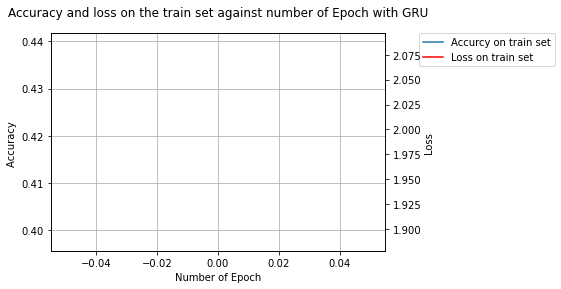

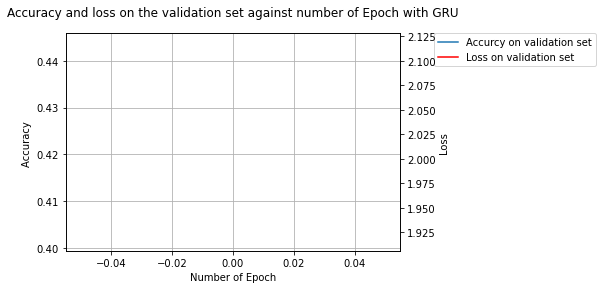

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(history.epoch,history.history['accuracy'],'-',label='Accurcy on train set')
ax2 = ax.twinx()
lns2 = ax2.plot(history.epoch,history.history['loss'],'-r',label='Loss on train set')

lns = lns1 + lns2
labs=[l.get_label() for l in lns]
ax.legend(lns,labs,loc=2,bbox_to_anchor=(1.1,1.0),borderaxespad=0.)

ax.grid()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Accuracy ")
ax2.set_ylabel("Loss ")
ax.set_title('Accuracy and loss on the train set against number of Epoch with GRU',y=1.05)

import matplotlib.pyplot as plt
import matplotlib
fig=plt.figure()
ax=fig.add_subplot(111)
lns1=ax.plot(history.epoch,history.history['val_accuracy'],'-',label='Accurcy on validation set')
ax2=ax.twinx()
lns2=ax2.plot(history.epoch,history.history['val_loss'],'-r',label='Loss on validation set')

lns=lns1+lns2
labs=[l.get_label() for l in lns]
ax.legend(lns,labs,loc=2,bbox_to_anchor=(1.1,1.0),borderaxespad=0.)

ax.grid()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Accuracy ")
ax2.set_ylabel("Loss ")
ax.set_title('Accuracy and loss on the validation set against number of Epoch with GRU',y=1.05)

Explore model variants with different recurrent units (“vanilla”, LSTM, and GRU), number of layers, different depths and layer sizes for the multi-layer perceptron, etc. to find what works well on the validation set and describe the process through which you arrive at your final model.

In [23]:
n_hidden = 30  # size of hidden layer in RNN
# Build Model
batch_input_shape = (None, maxlen, len(chars))

model = Sequential()
model.add(GRU(n_hidden,activation = 'tanh', batch_input_shape = batch_input_shape, return_sequences = True))
#model.add(SimpleRNN(n_hidden,activation='tanh', batch_input_shape=batch_input_shape,return_sequences=True))
#model.add(SimpleRNN(n_hidden,activation='tanh', batch_input_shape=batch_input_shape))
model.add(GRU(n_hidden,activation = 'tanh'))
model.add(layers.Dense(len(chars), activation = 'softmax'))
#model.add(Dropout(0.4))
adam = keras.optimizers.Adam(lr = 0.001,beta_1 = 0.9,beta_2 = 0.999,epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = 'categorical_crossentropy', optimizer = adam,metrics = ['accuracy'])

history = model.fit(x, y, batch_size = 128, epochs = 50, validation_data = (val_x, val_y))

Epoch 1/50
865/865 [==============================] - 65s 75ms/step - loss: 2.9830 - accuracy: 0.2024 - val_loss: 2.6485 - val_accuracy: 0.2665
Epoch 2/50
865/865 [==============================] - 66s 76ms/step - loss: 2.4774 - accuracy: 0.3019 - val_loss: 2.3533 - val_accuracy: 0.3315
Epoch 3/50
865/865 [==============================] - 62s 71ms/step - loss: 2.2756 - accuracy: 0.3502 - val_loss: 2.2221 - val_accuracy: 0.3624
Epoch 4/50
865/865 [==============================] - 59s 68ms/step - loss: 2.1678 - accuracy: 0.3774 - val_loss: 2.1379 - val_accuracy: 0.3866
Epoch 5/50
865/865 [==============================] - 59s 68ms/step - loss: 2.0970 - accuracy: 0.3952 - val_loss: 2.0840 - val_accuracy: 0.3973
Epoch 6/50
865/865 [==============================] - 59s 68ms/step - loss: 2.0471 - accuracy: 0.4059 - val_loss: 2.0517 - val_accuracy: 0.4050
Epoch 7/50
865/865 [==============================] - 59s 68ms/step - loss: 2.0109 - accuracy: 0.4143 - val_loss: 2.0126 - val_accuracy:

Text(0.5, 1.05, 'Accuracy\xa0and\xa0loss\xa0on\xa0the\xa0validation\xa0set\xa0against\xa0number\xa0of\xa0Epoch\xa0with\xa0GRU')

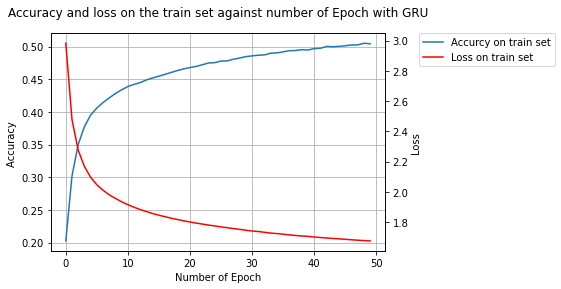

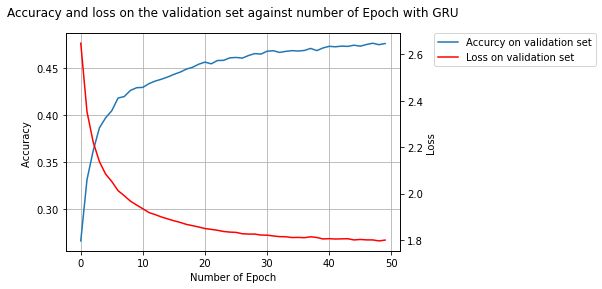

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(history.epoch,history.history['accuracy'],'-',label='Accurcy on train set')
ax2 = ax.twinx()
lns2 = ax2.plot(history.epoch,history.history['loss'],'-r',label='Loss on train set')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 2, bbox_to_anchor = (1.1, 1.0), borderaxespad = 0.)

ax.grid()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Accuracy ")
ax2.set_ylabel("Loss ")
ax.set_title('Accuracy and loss on the train set against number of Epoch with GRU',y=1.05)

import matplotlib.pyplot as plt
import matplotlib
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(history.epoch,history.history['val_accuracy'],'-',label = 'Accurcy on validation set')
ax2 = ax.twinx()
lns2 = ax2.plot(history.epoch,history.history['val_loss'],'-r',label = 'Loss on validation set')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc=2,bbox_to_anchor = (1.1, 1.0), borderaxespad = 0.)

ax.grid()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Accuracy ")
ax2.set_ylabel("Loss ")
ax.set_title('Accuracy and loss on the validation set against number of Epoch with GRU', y = 1.05)

In [25]:
model = keras.models.Sequential()
#128 units
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
#output softmax
model.add(layers.Dense(len(chars), activation='softmax'))

# The model compilation configuration
adam=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

history = model.fit(x, y, batch_size=128, epochs=60,validation_data=(val_x,val_y))

Epoch 1/60
865/865 [==============================] - 95s 109ms/step - loss: 2.8109 - accuracy: 0.2349 - val_loss: 2.5373 - val_accuracy: 0.2810
Epoch 2/60
865/865 [==============================] - 94s 108ms/step - loss: 2.4303 - accuracy: 0.3089 - val_loss: 2.3671 - val_accuracy: 0.3153
Epoch 3/60
865/865 [==============================] - 94s 109ms/step - loss: 2.2949 - accuracy: 0.3367 - val_loss: 2.2593 - val_accuracy: 0.3467
Epoch 4/60
865/865 [==============================] - 93s 108ms/step - loss: 2.2216 - accuracy: 0.3552 - val_loss: 2.2044 - val_accuracy: 0.3630
Epoch 5/60
865/865 [==============================] - 93s 108ms/step - loss: 2.1707 - accuracy: 0.3681 - val_loss: 2.1581 - val_accuracy: 0.3720
Epoch 6/60
865/865 [==============================] - 94s 108ms/step - loss: 2.1278 - accuracy: 0.3769 - val_loss: 2.1197 - val_accuracy: 0.3760
Epoch 7/60
865/865 [==============================] - 94s 108ms/step - loss: 2.0904 - accuracy: 0.3858 - val_loss: 2.0851 - val_ac

865/865 [==============================] - 93s 107ms/step - loss: 1.5010 - accuracy: 0.5500 - val_loss: 1.7613 - val_accuracy: 0.4956
Epoch 58/60
865/865 [==============================] - 93s 107ms/step - loss: 1.4966 - accuracy: 0.5511 - val_loss: 1.7553 - val_accuracy: 0.4977
Epoch 59/60
865/865 [==============================] - 93s 108ms/step - loss: 1.4915 - accuracy: 0.5530 - val_loss: 1.7559 - val_accuracy: 0.4938
Epoch 60/60
865/865 [==============================] - 92s 107ms/step - loss: 1.4865 - accuracy: 0.5529 - val_loss: 1.7578 - val_accuracy: 0.4966


Text(0.5, 1.05, 'Accuracy\xa0and\xa0loss\xa0on\xa0the\xa0validation\xa0set\xa0against\xa0number\xa0of\xa0Epoch\xa0with\xa0LSTM')

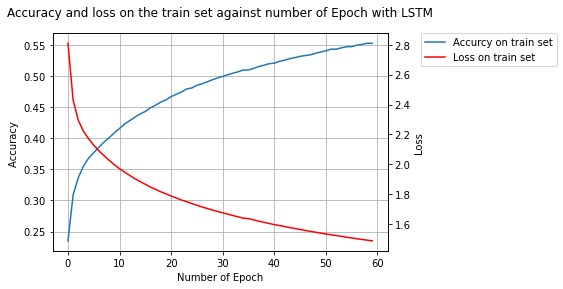

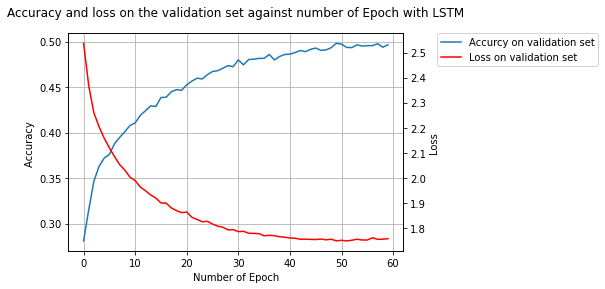

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(history.epoch,history.history['accuracy'],'-',label='Accurcy on train set')
ax2 = ax.twinx()
lns2 = ax2.plot(history.epoch,history.history['loss'],'-r',label='Loss on train set')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 2, bbox_to_anchor = (1.1, 1.0),borderaxespad = 0.)

ax.grid()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Accuracy ")
ax2.set_ylabel("Loss ")
ax.set_title('Accuracy and loss on the train set against number of Epoch with LSTM', y = 1.05)

fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(history.epoch,history.history['val_accuracy'],'-',label='Accurcy on validation set')
ax2 = ax.twinx()
lns2 = ax2.plot(history.epoch,history.history['val_loss'],'-r',label='Loss on validation set')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 2, bbox_to_anchor = (1.1, 1.0), borderaxespad = 0.)

ax.grid()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Accuracy ")
ax2.set_ylabel("Loss ")
ax.set_title('Accuracy and loss on the validation set against number of Epoch with LSTM', y = 1.05)

Text(0.5, 1.05, 'Loss\xa0on\xa0the\xa0training and validation\xa0set\xa0against\xa0number\xa0of\xa0Epoch\xa0with\xa0LSTM')

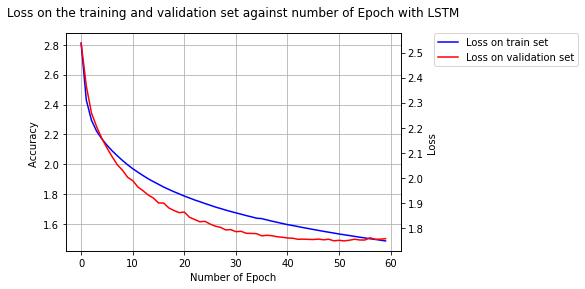

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(history.epoch,history.history['loss'],'-b',label='Loss on train set')
ax2 = ax.twinx()
lns2= ax2.plot(history.epoch,history.history['val_loss'],'-r',label='Loss on validation set')

lns=lns1+lns2
labs=[l.get_label() for l in lns]
ax.legend(lns,labs,loc=2,bbox_to_anchor=(1.1,1.0),borderaxespad=0.)

ax.grid()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Accuracy ")
ax2.set_ylabel("Loss ")
ax.set_title('Loss on the training and validation set against number of Epoch with LSTM',y=1.05)

In [29]:
print("Train set")
score = model.evaluate(x, y, batch_size = 128)
print("Validation set")
score = model.evaluate(val_x, val_y, batch_size = 128)
print("Test set")
score = model.evaluate(test_x, test_y, batch_size = 128)

Train set
865/865 [==============================] - 35s 40ms/step - loss: 1.4644 - accuracy: 0.5613
Validation set
113/113 [==============================] - 4s 40ms/step - loss: 1.7578 - accuracy: 0.4966
Test set
224/224 [==============================] - 9s 40ms/step - loss: 1.7567 - accuracy: 0.4974


In [30]:
char_indices

{' ': 0,
 '!': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 '*': 7,
 '+': 8,
 ',': 9,
 '-': 10,
 '.': 11,
 '/': 12,
 '0': 13,
 '1': 14,
 '2': 15,
 '3': 16,
 '4': 17,
 '5': 18,
 '6': 19,
 '7': 20,
 '8': 21,
 '9': 22,
 ':': 23,
 ';': 24,
 '=': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 '\\': 53,
 '`': 54,
 'a': 55,
 'b': 56,
 'c': 57,
 'd': 58,
 'e': 59,
 'f': 60,
 'g': 61,
 'h': 62,
 'i': 63,
 'j': 64,
 'k': 65,
 'l': 66,
 'm': 67,
 'n': 68,
 'o': 69,
 'p': 70,
 'q': 71,
 'r': 72,
 's': 73,
 't': 74,
 'u': 75,
 'v': 76,
 'w': 77,
 'x': 78,
 'y': 79,
 'z': 80,
 '찼': 81,
 '창': 82,
 '찾': 83,
 '챈': 84,
 '챌': 85,
 '챔': 86,
 '챕': 87,
 '챠': 88,
 '챦': 89,
 '챰': 90,
 '처': 91,
 '척': 92,
 '철': 93,
 '청': 94,
 '체': 95,
 '혻': 96,
 '횪': 97}

In [31]:
chars

[' ',
 '!',
 '#',
 '$',
 '%',
 '&',
 "'",
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '\\',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '찼',
 '창',
 '찾',
 '챈',
 '챌',
 '챔',
 '챕',
 '챠',
 '챦',
 '챰',
 '처',
 '척',
 '철',
 '청',
 '체',
 '혻',
 '횪']

In [32]:
model = keras.models.Sequential()
#128 units
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
#output softmax
model.add(layers.Dense(len(chars), activation='softmax'))

# The model compilation configuration
adam = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# The text generation loop
import random
import sys

for epoch in range(1, 60):
    print('epoch', epoch)
    #training
    model.fit(x, y, batch_size = 128, epochs = 1)

    #select some characters from the training text
    generated_text = text[0:maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    temperature = 0.5
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    i = 0
    while i < 5:
      sampled = np.zeros((1, maxlen, len(chars)))
      for t, char in enumerate(generated_text):
          #one hot
          sampled[0, t, char_indices[char]] = 1.

      # get the distribution of the preds,the sum of the probability is 1
      preds = model.predict(sampled, verbose = 0)[0]
      # print the most possible index
      next_index = sample1(preds, temperature)
      # get the characters from the char indices
      next_char = chars[next_index]
      if next_index == 11:#determine whether the prediction is a '.',which ends a sentence
        i = i + 1

      generated_text += next_char
      generated_text = generated_text[1:]

      sys.stdout.write(next_char)
      sys.stdout.flush()
    print()

epoch 1
865/865 [==============================] - 94s 109ms/step - loss: 2.7907 - accuracy: 0.2407
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splashe ane on is out angoos an and tha . . the wob an it on ee thar sorly mee ans ante in sone . ane ou mor there . amithe le mof in ance the thes an ee das end pore fore and .
epoch 2
865/865 [==============================] - 93s 108ms/step - loss: 2.3799 - accuracy: 0.3205
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash the the tha the the wers and alle ang map the as and the fur sure in wor sead , che s ant and thar . The nere angy she . 

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash comp abor sole a gerter that the faich the not 's a farm the hound has has to not inte with a sulled , and the senely be out of pithing . The firmert this dear , in the lovie that in it a compector . The goon movie of mene the poot the punding comedion . It 's ineresting of the hourd the sorfing there coming this a gough the entice . Patter , must of intrough the sirder the pilare that make the the mories , but hark that the some that it more , aroud the more has its the last of the secrions to the movie .
epoch 11
865/865 [==============================] - 86s 100ms/step - loss: 1.9209 - accuracy: 0.4302
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash strent . The some the may and fi

865/865 [==============================] - 88s 101ms/step - loss: 1.7346 - accuracy: 0.4847
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splasher 's sone-the movie to concemist . It 's gristing . It 's a film , in a compenton . A deations . It 's something .
epoch 22
865/865 [==============================] - 93s 108ms/step - loss: 1.7207 - accuracy: 0.4882
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splashous from the screen , the scones film a word no concerical ene of the film that a neere camentices to do so so sanal can the film , to be the the story in the sanaming seem to cartare a

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash study of farger dean from the selie with the has cells in the surpers and contrived be a boughts the scory that it is spension . A work from too aday film that is to convintion of the dereation and expected by the never prope in the proves of the film to be the movie like the film 's vidually seems the film in the pretery in the movie . A film that and the screen . A conviturately condentily in the film . The film , the screen .
epoch 33
865/865 [==============================] - 87s 100ms/step - loss: 1.5972 - accuracy: 0.5237
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splashis . This movie . The film from some . Bot to be is story in the still in the film 's concept . It 's but in the

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splashing prode to surver movie . It 's a slords to be a vinge proved the matter that movie . Althought all of his look of the more the sightfully offerfully vellained Bamention . A contribal and many and it 's does a cap of the director that it 's a movie and their rellashive contining it are of the subject , and the director Master and a carent that is a film film . A ghosely makes this and sinching and the stars .
epoch 44
865/865 [==============================] - 89s 103ms/step - loss: 1.5059 - accuracy: 0.5498
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splashing the sour and more part in the film some play , and character and so starts this movie , and remacking and it 's a seen a more o

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splashing the movie story . Whenemat concept in a sweet the sensional part of a movie seems to be best a consticking as his lyfe , and the sellerd . What the movie . It 's so well action getely selest and a long audism . The screen .
epoch 56
865/865 [==============================] - 96s 111ms/step - loss: 1.4284 - accuracy: 0.5727
--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash"
------ temperature: 0.5
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splashing , and stuff , the film good and rost the film is a compless entertaining and the film that will adought , and a great very , and out of the film is a cride that is not a long as the film . A lond the work , and the way the liveration . And the entire to be a stars and history -- and storytelling and strong consis

In [39]:
model = keras.models.Sequential()
#128 units
model.add(layers.LSTM(128, input_shape = (maxlen, len(chars))))
#output softmax
model.add(layers.Dense(len(chars), activation = 'softmax'))

# The model compilation configuration
adam = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

import random
import sys

generated_text = text[0:70]
print('--- Generating with seed: "' + generated_text + '"')

for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)
    next_char = ['']
    for i in range (0, 4):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        #get the distribution of probabilities
        preds = model.predict(sampled, verbose=0)[0]
        #print the most possibile index
        next_index = sample1(preds, temperature)
        #get the characters
        next_char = chars[next_index]
#         if next_index = 11:
#            i = i + 1
        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "The Rock is destined to be the 21st Century 's new `` Conan '' and tha"
------ temperature: 0.2
The Rock is destined to be the 21st Century 's new `` Conan '' and thaA-L챕
------ temperature: 0.5
Rock is destined to be the 21st Century 's new `` Conan '' and thaA-L챕NARD
------ temperature: 1.0
 is destined to be the 21st Century 's new `` Conan '' and thaA-L챕NARD9CX철
------ temperature: 1.2
destined to be the 21st Century 's new `` Conan '' and thaA-L챕NARD9CX철챈V?%
